In [54]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import re

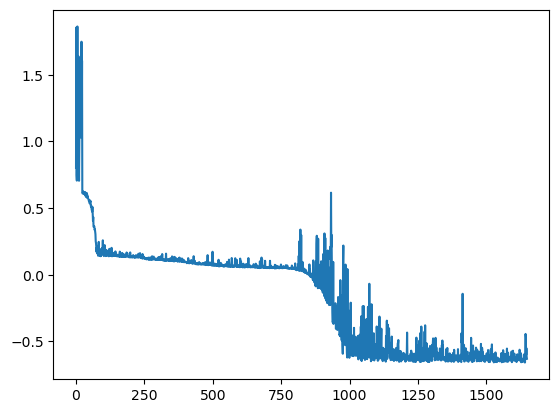

In [55]:
df_res = pd.read_csv('db_set.csv')
plt.plot(df_res.index, np.log10(df_res['err']))


In [56]:
para_opt = df_res.iloc[np.argmin(df_res['err']), 0:37]

In [57]:
min(df_res['err'])
df_res['index'].iloc[np.argmin(df_res['err'])]

'Bayesian_Opt 1620'

In [58]:
class KinetModifier:
    def __init__(self):
        # define the experimental data
        self.exp_list = ['H2', 'CH4', 'C2H6', 'C2H4', 'C2H2', 'C3H8', 'C3H6', 'C4H10', 'C5H12', 
                        'C', 'CH', 'CH2', 'CH3', 'C2H3', 'C2H5', 'C3H7', 'H',
                        'CH3^+', 'CH4^+', 'CH5^+', 'C2H2^+', 'C2H4^+', 'C2H5^+', 'C2H6^+', 'C3H6^+', 'C3H8^+']
        self.exp_values = [5.319082, 90.80403, 2.428802, 0.197735, 0.171795, 0.717088, 0.046734, 
                          0.114829, 0.119573, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.kinet_path = 'kinet_opt.inp'
        self.exe_path = 'run2.exe'

    def modify_parameter(self, param_name: str, new_value: float) -> None:
        # modify the parameter value in the kinet.inp file
        with open (self.kinet_path, 'r') as f:
            content = f.read()
        
        # modify the parameter
        pattern = rf'(parameter :: {param_name} = )([\d\.\+\-d]+)'
        new_value_str = f'{new_value:.4e}'.replace('e', 'd')
        content = re.sub(pattern, f'parameter :: {param_name} = {new_value_str}', content)

        with open(self.kinet_path, 'w') as f:
            f.write(content)
    
    def run_preprocessor(self):
        process = subprocess.Popen(  # 외부 프로세스 실행을 위한 Popen 객체 생성
        './preprocessor.exe',    # 실행할 프로그램 경로 지정
        stdin=subprocess.PIPE,   # 표준 입력 파이프 설정 - 프로세스에 입력을 전달하기 위함
        stdout=subprocess.PIPE,  # 표준 출력 파이프 설정 - 프로세스의 출력을 받기 위함
        stderr=subprocess.PIPE,  # 표준 에러 파이프 설정 - 프로세스의 에러를 받기 위함
        universal_newlines=False) # 텍스트 모드로 파이프 처리 - 문자열을 자동으로 인코딩/디코딩

        process.stdin.write(f'{self.kinet_path}\n'.encode())  # 입력 파일 경로를 프로세스에 전달
        process.stdin.flush()  # 버퍼를 비워서 데이터가 즉시 전송되도록 함

        process.stdin.write('.\n'.encode())  # 현재 디렉토리 표시를 프로세스에 전달
        process.stdin.flush()  # 버퍼를 비워서 데이터가 즉시 전송되도록 함

        output, error = process.communicate()  # 프로세스 실행 완료를 기다리고 출력과 에러를 받음
        output_str = output.decode('utf-8', errors='ignore') if output else ''
        error_str = error.decode('utf-8', errors='ignore') if error else ''
    
        print('check the run of preprocessor')  # 전처리기 실행 확인 메시지 출력 
        return output_str, error_str
    
    def compile_zdp(self):
        compile_command = [  # 컴파일 명령어 리스트 생성
        'gfortran', '-o', self.exe_path, 'dvode_f90_m.F90', 'zdplaskin_m.F90', 'run2.F90', 'bolsig_x86_64_g.dll'
        ]
        result = subprocess.run(compile_command, capture_output=True, text=True)  # 컴파일 명령 실행
    
        if result.returncode != 0:  # 컴파일 결과 확인
            raise Exception(f"{self.exe_path} 컴파일 실패")  # 컴파일 실패시 예외 발생
        print('check the compile_zdp')  # 컴파일 완료 메시지 출력

    def run_simulation(self):
        try:
            process = subprocess.Popen(  # 실행 파일 실행
                self.exe_path,    
                stdout=subprocess.PIPE,  
                stderr=subprocess.STDOUT,  
                stdin=subprocess.PIPE,   
                universal_newlines=True,
                bufsize=1,              
            )
            
            while True:
                output = process.stdout.readline()
                
                if not output:
                    break
                    
                print(f'\r{output.strip()}                                                                              ',end='',flush=True)
                
                if "PRESS ENTER TO EXIT" in output:
                    print()
                    process.kill()
                    break

                if "WARNING: BOLSIG+ convergence failed" in output:
                    process.stdin.write('\n')
                    process.stdin.flush()

        except:
            pass
        return process
                   
    def report_result(self):
        # read the result file
        species = []
        with open('qt_species_list.txt', 'r') as f:
            for line in f:
                comp = line[2:]
                species.append(comp.strip())
        
        df_sp = pd.read_csv('qt_densities.txt', sep=r'\s+', header=0, names=['Time [s]']+species)
        
        # calculate the concentration
        H2 = (df_sp['H2'])
        CH4 = (df_sp['CH4'] + df_sp['CH4(V13)'] + df_sp['CH4(V24)'])
        C2H2 = (df_sp['C2H2'] + df_sp['C2H2(V2)'] + df_sp['C2H2(V5)'] + df_sp['C2H2(V13)'])
        C2H4 = (df_sp['C2H4'] + df_sp['C2H4(V1)'] + df_sp['C2H4(V2)'])
        C2H6 = (df_sp['C2H6'] + df_sp['C2H6(V13)'] + df_sp['C2H6(V24)'])
        C3H6 = (df_sp['C3H6'] + df_sp['C3H6(V)'])
        C3H8 = (df_sp['C3H8'] + df_sp['C3H8(V1)'] + df_sp['C3H8(V2)'])
        C4H10 = (df_sp['C4H9H'])
        C5H12 = (df_sp['C5H12'])
        C = (df_sp['C'])
        CH = (df_sp['CH'])
        CH2 = (df_sp['CH2'])
        CH3 = (df_sp['CH3'])
        C2H3 = (df_sp['C2H3'])
        C2H5 = (df_sp['C2H5'])
        C3H7 = (df_sp['C3H7'])
        H = (df_sp['H'])
        CH3_plus = (df_sp['CH3^+'])
        CH4_plus = df_sp['CH4^+']
        CH5_plus = df_sp['CH5^+']
        C2H2_plus = df_sp['C2H2^+']
        C2H4_plus = df_sp['C2H4^+']
        C2H5_plus = df_sp['C2H5^+']
        C2H6_plus = df_sp['C2H6^+']
        C3H6_plus = df_sp['C3H6^+']
        C3H8_plus = df_sp['C3H8^+']

        all_sp = df_sp.sum(axis=1) - df_sp['E']

        t = abs(df_sp['Time [s]']-16.96).argmin()

        sim_H2 = float(format(H2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH4 = float(format(CH4.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H2 = float(format(C2H2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H4 = float(format(C2H4.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H6 = float(format(C2H6.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H6 = float(format(C3H6.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H8 = float(format(C3H8.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C4H10 = float(format(C4H10.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C5H12 = float(format(C5H12.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C = float(format(C.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH = float(format(CH.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH2 = float(format(CH2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH3 = float(format(CH3.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H3 = float(format(C2H3.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H5 = float(format(C2H5.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H7 = float(format(C3H7.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_H = float(format(H.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH3_plus = float(format(CH3_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH4_plus = float(format(CH4_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH5_plus = float(format(CH5_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H2_plus = float(format(C2H2_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H4_plus = float(format(C2H4_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H5_plus = float(format(C2H5_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H6_plus = float(format(C2H6_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H6_plus = float(format(C3H6_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H8_plus = float(format(C3H8_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))

        sim = []
        sim.append(sim_H2)
        sim.append(sim_CH4)
        sim.append(sim_C2H6)
        sim.append(sim_C2H4)
        sim.append(sim_C2H2)
        sim.append(sim_C3H8)
        sim.append(sim_C3H6)
        sim.append(sim_C4H10)
        sim.append(sim_C5H12)
        sim.append(sim_C)
        sim.append(sim_CH)
        sim.append(sim_CH2)
        sim.append(sim_CH3)
        sim.append(sim_C2H3)
        sim.append(sim_C2H5)
        sim.append(sim_C3H7)
        sim.append(sim_H)
        sim.append(sim_CH3_plus)
        sim.append(sim_CH4_plus)
        sim.append(sim_CH5_plus)
        sim.append(sim_C2H2_plus)
        sim.append(sim_C2H4_plus)
        sim.append(sim_C2H5_plus)
        sim.append(sim_C2H6_plus)
        sim.append(sim_C3H6_plus)
        sim.append(sim_C3H8_plus)

        result = pd.DataFrame({
        'species': self.exp_list,
        'exp': self.exp_values,
        'sim': [sim_H2, sim_CH4, sim_C2H6, sim_C2H4, sim_C2H2, sim_C3H8, sim_C3H6, sim_C4H10, sim_C5H12, 
                sim_C, sim_CH, sim_CH2, sim_CH3, sim_C2H3, sim_C2H5, sim_C3H7, sim_H,  # 라디칼 종
                sim_CH3_plus, sim_CH4_plus, sim_CH5_plus, sim_C2H2_plus, sim_C2H4_plus, 
                sim_C2H5_plus, sim_C2H6_plus, sim_C3H6_plus, sim_C3H8_plus]  # 이온 종
        })

        err = 0
        for i in range(len(self.exp_values)):
            err += ((self.exp_values[i] - sim[i]))**2
        err -= (self.exp_values[8] - sim[8])**2
        err -= (self.exp_values[9] - sim[9])**2

        print(result)
        print(err)


In [59]:

if __name__ == "__main__":
    para_value = list(para_opt.values)
    kinet_modifier = KinetModifier()
    for i in range(len(para_opt)):
        kinet_modifier.modify_parameter(f'f{i}', para_value[i])
    kinet_modifier.run_preprocessor()
    kinet_modifier.compile_zdp()
    kinet_modifier.run_simulation()
    kinet_modifier.report_result()


check the run of preprocessor
check the compile_zdp
PRESS ENTER TO EXIT ...At line 88 of file run2.F90 (unit = 5, file = 'fort.5')                                                                                         
   species        exp        sim
0       H2   5.319082   5.174797
1      CH4  90.804030  90.772875
2     C2H6   2.428802   2.471528
3     C2H4   0.197735   0.321619
4     C2H2   0.171795   0.003178
5     C3H8   0.717088   0.900445
6     C3H6   0.046734   0.019717
7    C4H10   0.114829   0.007869
8    C5H12   0.119573   0.000004
9        C   0.000000   0.001610
10      CH   0.000000   0.000000
11     CH2   0.000000   0.000000
12     CH3   0.000000   0.325969
13    C2H3   0.000000   0.000001
14    C2H5   0.000000   0.000386
15    C3H7   0.000000   0.000000
16       H   0.000000   0.000004
17   CH3^+   0.000000   0.000000
18   CH4^+   0.000000   0.000000
19   CH5^+   0.000000   0.000000
20  C2H2^+   0.000000   0.000000
21  C2H4^+   0.000000   0.000000
22  C2H5^+   0.000000